In [1]:
from os.path import join
import torch
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xgboost as xgb

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

import sys
sys.path.append("/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/scTab-devel/notebooks/model_evaluation")
from utils import correct_labels

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
CKPT_PATH = '/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/model_XGBoost/run1/xgb_embedding_model.json'

In [6]:
clf = xgb.XGBClassifier()
clf.load_model(CKPT_PATH)
clf.set_params(predictor='gpu_predictor')
clf

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False, eta=0.075,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=20, num_parallel_tree=1, objective='multi:softprob',
              predictor='gpu_predictor', random_state=0, ...)

In [7]:
DATA_PATH = '/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL'

test_emb = torch.load(join(DATA_PATH, "test_embedding.pt"), weights_only=True)
x_test = test_emb["X"]
y_test = test_emb["y"]
unique_test_labels = torch.unique(y_test)

In [9]:
y_test_numpy = y_test.numpy()
z0_obs_all = []

unique_test_labels = torch.unique(y_test)
for class_idx in range(len(unique_test_labels)):
    class_idxs = np.where(y_test_numpy == unique_test_labels[class_idx].item())[0]
    z0_obs = x_test[class_idxs].mean(dim=0).to(device)
    z0_obs_all.append(z0_obs)

In [10]:
z0_obs_all

[tensor([0.2574, 1.6586, 0.4568, 1.5055, 0.2876, 1.1960, 0.3572, 1.1473, 1.2365,
         2.2799, 0.5212, 0.3709, 0.1108, 1.1809, 0.0727, 0.7460, 0.5597, 0.2812,
         0.4363, 0.3596, 0.6250, 0.5482, 1.0734, 0.4402, 0.0954, 0.3622, 0.8038,
         0.9720, 0.1316, 0.2632, 0.6290, 0.2018, 0.2647, 0.2797, 0.6597, 0.2709,
         0.5990, 0.0591, 0.3159, 0.2487, 2.9257, 2.4597, 0.1692, 1.2036, 0.8944,
         0.1365, 0.8339, 0.7211, 1.3321, 0.6512, 0.1908, 0.0789, 0.7598, 0.9370,
         0.4645, 0.4056, 0.5244, 0.3318, 0.3532, 0.2425, 0.2597, 0.7220, 0.0510,
         0.7997, 0.5881, 0.8788, 0.3469, 0.5711, 0.2761, 1.0391, 0.4340, 2.0084,
         0.7171, 0.1535, 0.5874, 0.2677, 0.8145, 1.6251, 0.3479, 1.3602, 0.6144,
         1.4169, 1.6522, 0.5497, 1.3781, 2.0315, 0.5390, 0.2642, 0.5525, 0.1100,
         1.5613, 0.3621, 0.4338, 1.8296, 0.2220, 1.7159, 0.0420, 0.2455, 0.8016,
         0.2809, 0.7657, 0.5000, 0.3301, 0.2712, 0.2376, 0.0838, 0.5299, 1.0324,
         1.3316, 0.8375, 0.3

In [12]:
z0_obs_all_np = torch.stack(z0_obs_all).cpu().numpy()  # shape: (n_samples, n_features)

In [13]:
print(z0_obs_all_np.shape)  # should be (164, feature_dim)

(164, 128)


In [14]:
y_pred = clf.predict(z0_obs_all_np)

In [15]:
y_true = unique_test_labels

In [16]:
assert y_pred.shape[0] == y_true.shape[0]

In [17]:
y_true = np.asarray(y_true, dtype=np.int64).ravel()
y_pred = np.asarray(y_pred, dtype=np.int64).ravel()

In [18]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Predict on test set
# Evaluate performance
accuracy = accuracy_score(unique_test_labels, y_pred)
f1 = f1_score(unique_test_labels, y_pred, average='weighted')
report = classification_report(unique_test_labels, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Accuracy: 0.9390
Test F1-score: 0.9197
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       0.50      1.00      0.67         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       0.33      1.00      0.50         1
          15       1.00      1.00      1.00         1
          16  

/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

clf_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projects/b1042/GoyalLab/jaekj/python/scTAB/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

,precision,recall,f1-score,support
accuracy,0.939024,0.939024,0.939024,0.939024
macro avg,0.910569,0.939024,0.919715,164.000000
weighted avg,0.910569,0.939024,0.919715,164.000000


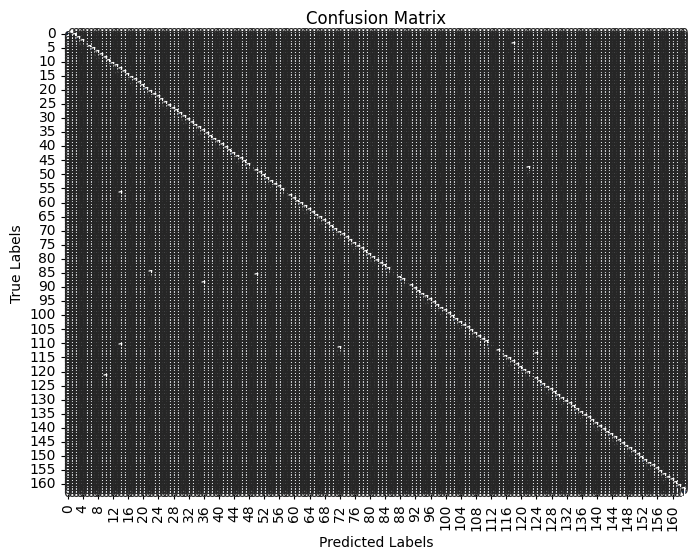

In [20]:
cm = confusion_matrix(unique_test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [21]:
DATA_PATH = '/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/merlin_cxg_2023_05_15_sf-log1p'
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))

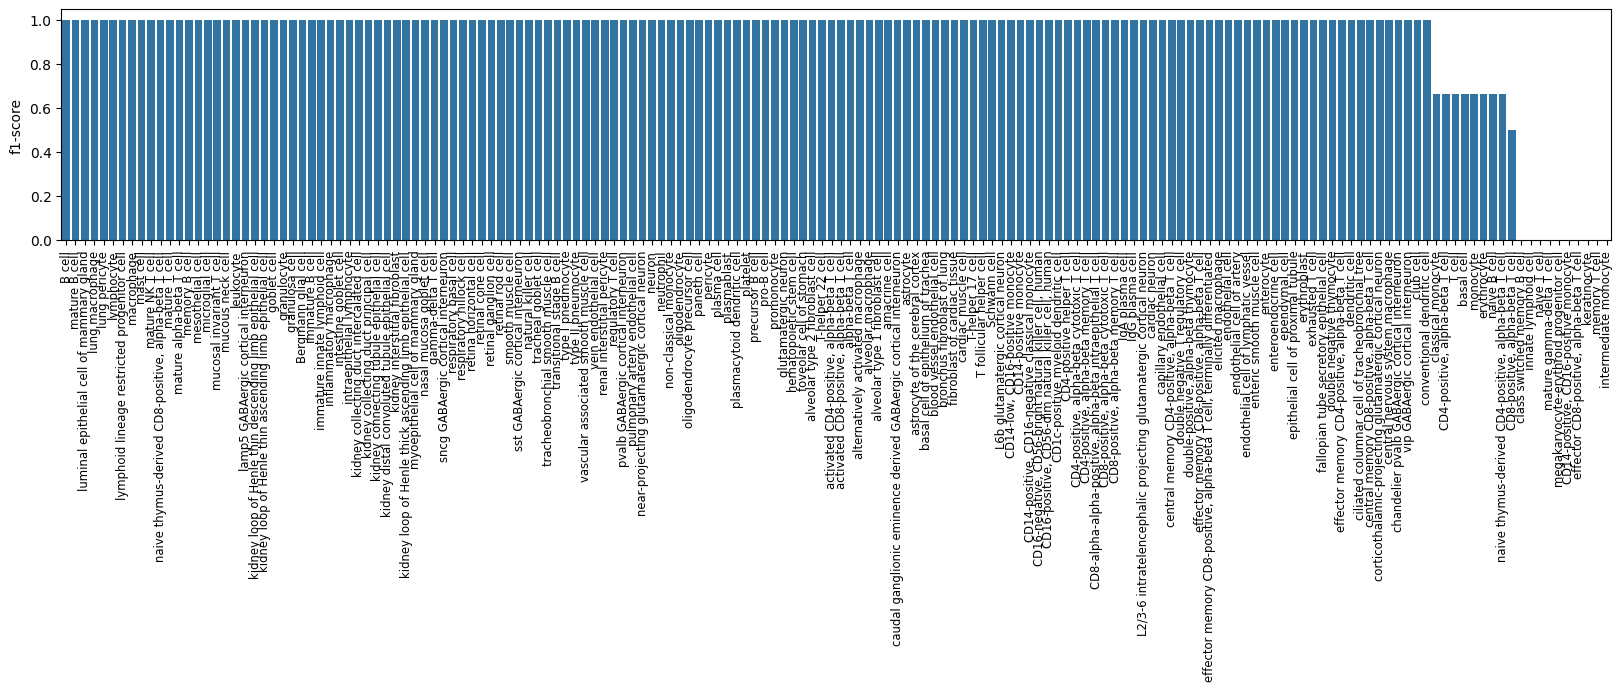

In [22]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
    color='#1f77b4'
)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.xaxis.set_tick_params(labelsize='small');